## check the image size (the most abnormal patient) 

In [11]:
print(torch.from_numpy(torch.load(r"processed data/stress/stressN183411831.pt")["image"]).shape)
print(torch.load(r"processed data/stress/stressN183411831.pt")["image"].max())

torch.Size([3, 15, 36])
1.0


## test data

{'checkpoint_dir': 'checkpoints/checkpoints_stress_Res18', 'checkpoint_name': 'model.ckpt-1340.pt', 'dataset_dir': '../../../metadata/stress', 'type': 'Res18'}
..\..\..\metadata\stress\test_set.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]

MPI test:
{'average_acc': 0.8717948717948718, 'average_precision': 0.42399267399267393, 'recall': 0.42857142857142855, 'auc': 0.6986607142857143, 'confusion_matrix': array([[31,  1],
       [ 4,  3]], dtype=int64)}
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        32
           1       0.75      0.43      0.55         7

    accuracy                           0.87        39
   macro avg       0.82      0.70      0.74        39
weighted avg       0.86      0.87      0.86        39



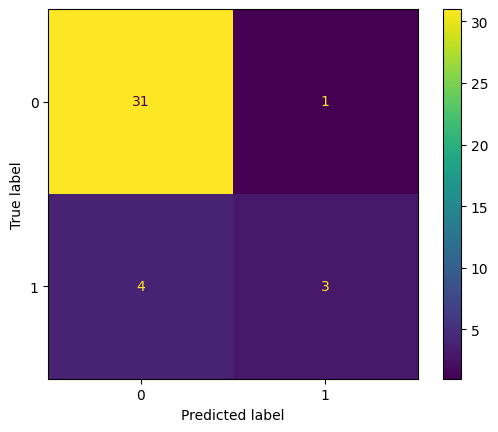

In [1]:
##stress
%run test_single.py

{'checkpoint_dir': 'checkpoints/checkpoints_rest_Res18', 'checkpoint_name': 'model.ckpt-3552.pt', 'dataset_dir': '../../../metadata/rest', 'type': 'Res18'}
..\..\..\metadata\rest\test_set.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.87it/s]

MPI test:
{'average_acc': 0.9230769230769231, 'average_precision': 0.47692307692307695, 'recall': 0.4, 'auc': 0.7, 'confusion_matrix': array([[34,  0],
       [ 3,  2]], dtype=int64)}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.40      0.57         5

    accuracy                           0.92        39
   macro avg       0.96      0.70      0.76        39
weighted avg       0.93      0.92      0.91        39



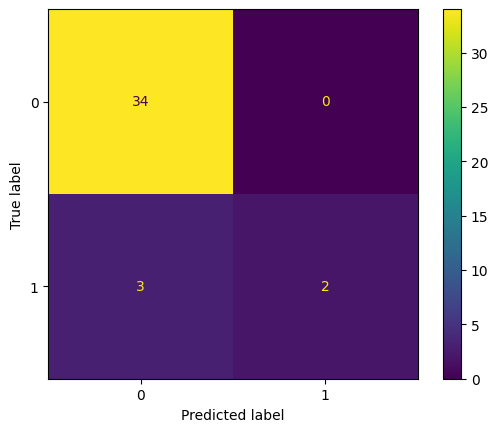

In [2]:
## rest
%run test_single.py

## Stress Classifier Localization

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils import MPIDataset,save_checkpoint, load_checkpoint,Evaluator
from models.Classifiers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [ ]:
model_stress = Res18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir=Path(r"checkpoints/checkpoints_stress_Res18")/"model.ckpt-1340.pt"
checkpoint=torch.load(checkpoint_dir)
model_stress.load_state_dict(checkpoint["model"])  
model_stress.to(device)
model_stress.eval()

## select out some abnormal sample and put it into tensor
input_tensor=torch.from_numpy(torch.load(r"processed data/stress/stressN183411831.pt")["image"]).unsqueeze(0)

target_layers = [model_stress.model.layer4[-1]]
# input_tensor = data['image'][23].unsqueeze(0).to(device)

cam = GradCAM(model=model_stress, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets=[BinaryClassifierOutputTarget(category=1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


In [ ]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
print(grayscale_cam)
cam_image = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=False)


## Rest Classifier Localization

In [ ]:
model_rest = Res18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir=Path(r"checkpoints/checkpoints_rest_Res18")/"model.ckpt-3552.pt"
checkpoint=torch.load(checkpoint_dir)
model_rest.load_state_dict(checkpoint["model"])  
model_rest.to(device)
model_rest.eval()

## select out some abnormal sample and put it into tensor
input_tensor=torch.from_numpy(torch.load(r"processed data/stress/stressN183411831.pt")["image"]).unsqueeze(0)

target_layers = [model_rest.model.layer4]
# input_tensor = data['image'][23].unsqueeze(0).to(device)

cam = GradCAM(model=model_rest, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets=[BinaryClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


In [ ]:
%matplotlib notebook

In [ ]:
plt.imshow(input_tensor.squeeze(0)[0],cmap='gray')
plt.colorbar()

In [ ]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
print(grayscale_cam)

plt.imshow(grayscale_cam,cmap='Reds')
plt.colorbar()